#### NOVA IMS / BSc in Data Science / Big Data Analysis 2024/2025
# <b>Group Project
#### Notebook `Students Alcohol Consumption`

#### Group:
- `Laura Matias (20221836)`
- `Marta Almendra (20221878)`
- `Matilde Casimiro (20221940)` 
- `Teresa Simão (20221873)` 

#### Dataset obtained from:
https://www.kaggle.com/datasets/uciml/student-alcohol-consumption

%md
#### Definition of the problem and objectives

This dataset was obtained in a survey that students from math and portuguese language courses in secondary school answered. However, in this notebook we will only explore the data concerning students from math courses. \
It contains a lot of social, gender and study information about students. The aim with this information is to perform exploratory data analysis to relate the different factors to the students' final grades and also try to apply unsupervised machine learning to obtain clusters of students with similar characteristics. The results of an analysis like this can be used by schools to better accomodate students and develop different educational processes and techniques for the various clusters.

#### Import libraries

In [0]:
pip install numpy==1.22.4

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from operator import add
from functools import reduce

from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum, abs
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, when, count

from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

!pip install umap-learn
!pip install graphframes
!pip install networkx

import umap 
from graphframes import GraphFrame
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/bin/python -m pip install --upgrade pip' command.


#### Import the data

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("Students Analysis").getOrCreate()


In [0]:
file_location = "/FileStore/tables/student_mat.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
students = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

display(students)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10
GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,4,2,1,2,5,10,15,15,15
GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,12,12,11
GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,6,6,5,6
GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,yes,no,yes,yes,yes,no,4,2,2,1,1,1,0,16,18,19
GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,yes,yes,yes,yes,yes,no,5,5,1,1,1,5,0,14,15,15


##### Variables Description

- **school**: student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira) 
- **sex**: student's sex (binary: 'F' - female or 'M' - male) 
- **age**: student's age (numeric: from 15 to 22) 
- **address**: student's home address type (binary: 'U' - urban or 'R' - rural)  
- **famsize**: family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)  
- **Pstatus**: parent's cohabitation status (binary: 'T' - living together or 'A' - apart)  
- **Medu**: mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)  
- **Fedu**: father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)  
- **Mjob**: mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')  
- **Fjob**: father's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')  
- **reason**: reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')  
- **guardian**: student's guardian (nominal: 'mother', 'father' or 'other')  
- **traveltime**: home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)  
- **studytime**: weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)  
- **failures**: number of past class failures (numeric: n if 1<=n<3, else 4)  
- **schoolsup**: extra educational support (binary: yes or no)  
- **famsup**: family educational support (binary: yes or no)  
- **paid**: extra paid classes within the course 
- **subject**: (Math or Portuguese) (binary: yes or no)  
- **activities**: extra-curricular activities (binary: yes or no)  
- **nursery**: attended nursery school (binary: yes or no)  
- **higher**: wants to take higher education (binary: yes or no)  
- **internet**: Internet access at home (binary: yes or no)  
- **romantic**: with a romantic relationship (binary: yes or no)  
- **famrel**: quality of family relationships (numeric: from 1 - very bad to 5 - excellent)  
- **freetime**: free time after school (numeric: from 1 - very low to 5 - very high)  
- **goout**: going out with friends (numeric: from 1 - very low to 5 - very high)  
- **Dalc**: workday alcohol consumption (numeric: from 1 - very low to 5 - very high)  
- **Walc**: weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)  
- **health**: current health status (numeric: from 1 - very bad to 5 - very good)  
- **absences**: number of school absences (numeric: from 0 to 93)  
- **G1**: first period grade (numeric: from 0 to 20)  
- **G2**: second period grade (numeric: from 0 to 20)  
- **G3**: final grade (numeric: from 0 to 20, output target)  

## 1. Data Cleaning

####1.1 Initial Look at the Data

In [0]:

#print just an initial schema of our data 
students.printSchema()

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: string (nullable = true)
 |-- Fedu: string (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: string (nullable = true)
 |-- studytime: string (nullable = true)
 |-- failures: string (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: string (nullable = true)
 |-- freetime: string (nullable = true)
 |-- goout: string (nullable = tr

In [0]:
print(f"Number of rows: \n {students.count()}") #printing our number of rows
print(f"\nNumber of columns: \n {len(students.columns)}") #printing our number of columns

Number of rows: 
 395

Number of columns: 
 33


#### 1.2. Handling Missing Values


In [0]:

# Check for missing values
missing_values = students.select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in students.columns])

# Show the count of missing values per column
display(missing_values)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


As we can see, no missing values were found in the dataset.

#### 1.2. Data Types


In [0]:
# Defining our numeric columns
numeric_columns = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

# Pass our numeric columns to IntegerType
for cols in numeric_columns:
    students= students.withColumn(cols, students[cols].cast(IntegerType()))


#### 1.4. Duplicate Values

We are going to check for duplicate values in our data

In [0]:
rows_before = students.count()

df_no_duplicates = students.dropDuplicates()

rows_after = df_no_duplicates.count()

has_duplicates = rows_before != rows_after

print("Has duplicate rows:", has_duplicates)

Has duplicate rows: False


As we can see, there are no duplicate values in the dataset.

## 2. Exploratory Data Analysis

In [0]:
students.count() 

Out[9]: 395

In [0]:
# Summary statistics
display(students.describe())

summary,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
mean,null,null,16.696202531645568,null,null,null,2.749367088607595,2.5215189873417723,null,null,null,null,1.4481012658227848,2.0354430379746837,0.3341772151898734,null,null,null,null,null,null,null,null,3.9443037974683546,3.2354430379746835,3.108860759493671,1.481012658227848,2.2911392405063293,3.5544303797468353,5.708860759493671,10.90886075949367,10.713924050632912,10.415189873417722
stddev,null,null,1.2760427246056265,null,null,null,1.0947351414285371,1.0882005458269433,null,null,null,null,0.6975047549086822,0.8392403464185556,0.7436509736062509,null,null,null,null,null,null,null,null,0.8966586076885046,0.9988620396657203,1.1132781740183422,0.8907414280909668,1.2878965924510932,1.3903033913095773,8.003095687108182,3.3191946715076686,3.7615046595560306,4.5814426109978434
min,GP,F,15,R,GT3,A,0,0,at_home,at_home,course,father,1,1,0,no,no,no,no,no,no,no,no,1,1,1,1,1,1,0,3,0,0
max,MS,M,22,U,LE3,T,4,4,teacher,teacher,reputation,other,4,4,3,yes,yes,yes,yes,yes,yes,yes,yes,5,5,5,5,5,5,75,19,19,20


#### 2.1. Variables Distributions

In [0]:
# Count unique values for categorical variables
display(students.select('school', 'sex', 'address', 'Mjob', 'Fjob').distinct())

school,sex,address,Mjob,Fjob
MS,F,R,other,services
GP,M,U,services,teacher
MS,M,U,teacher,services
GP,F,U,teacher,teacher
GP,M,R,at_home,at_home
GP,F,R,other,services
GP,F,R,services,at_home
GP,F,U,services,teacher
GP,F,U,other,at_home
GP,M,U,teacher,teacher


Final Grades Distribution

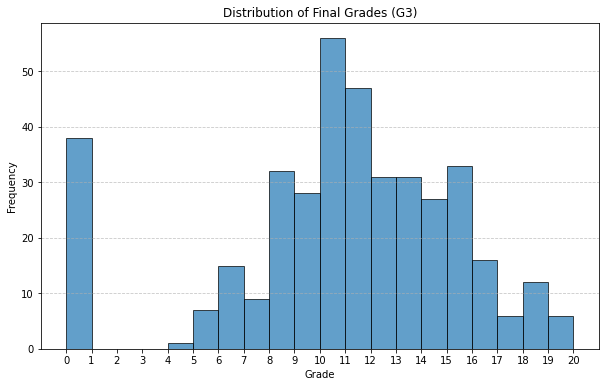

In [0]:
# Extract the final grades (G3 column) as a list of values
grades = students.select("G3").rdd.flatMap(lambda x: x).collect()

#Plot the histogram 
plt.figure(figsize=(10, 6))
plt.hist(grades, bins=range(0, 21), edgecolor='black', alpha=0.7)  # Bins from 0 to 20
plt.title("Distribution of Final Grades (G3)")
plt.xlabel("Grade")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(0, 21, 1))  # Grades from 0 to 20
plt.show()


From the histogram we can see that the most coomon final grades among students are between 10 and 12 values.

##### 2.1.1 Binary Variables

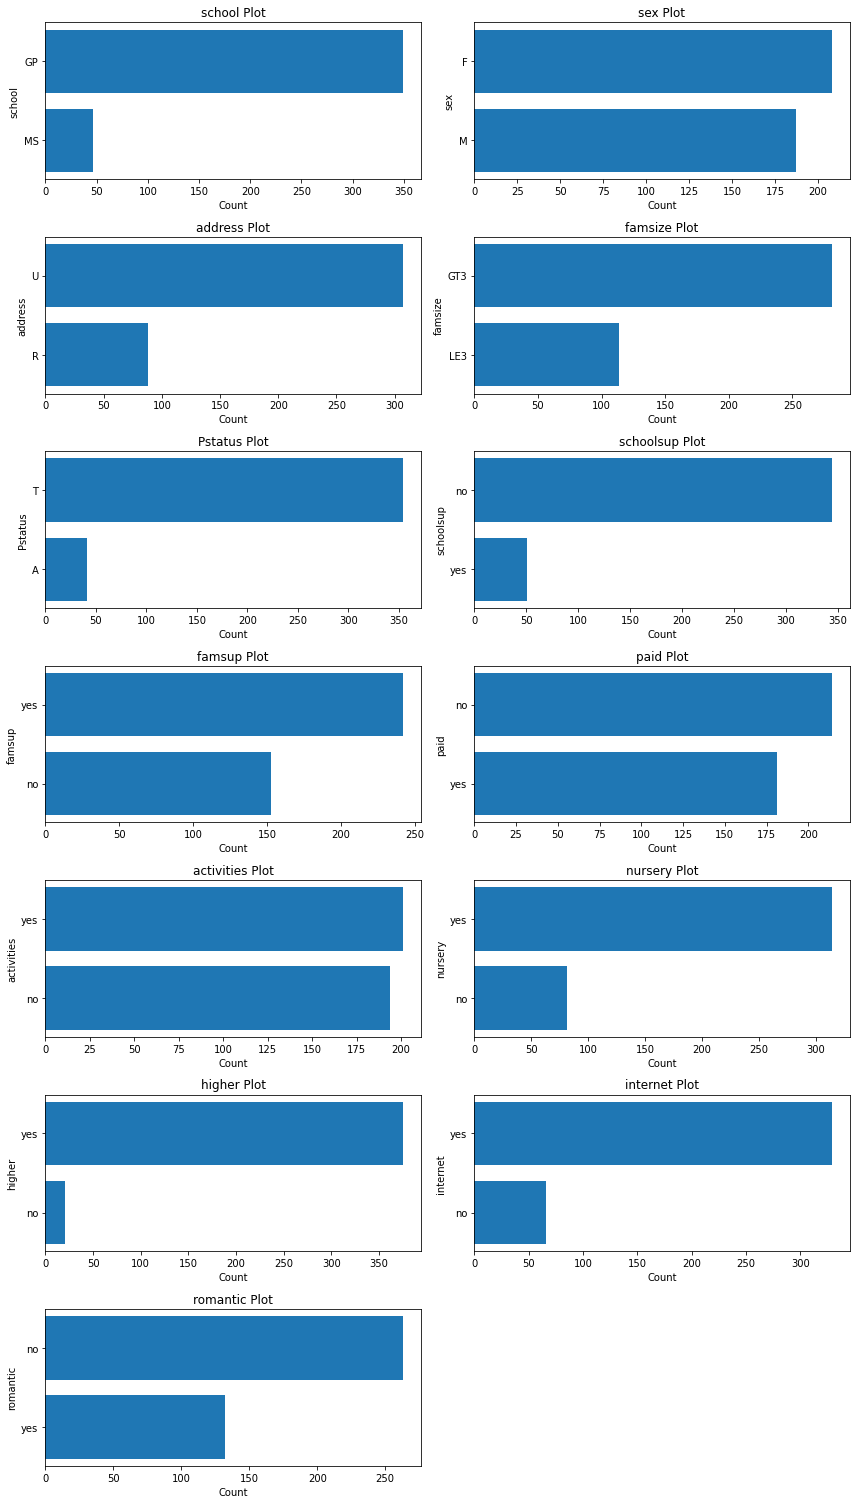

In [0]:
binary_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'] #defining the binary columns

num_columns = 2
num_rows = (len(binary_columns) + 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows *3))
axes = axes.flatten()  

for idx, variable in enumerate(binary_columns):
    variable_counts = students.groupBy(variable).count().orderBy('count', ascending=True)
    variable_count_list = variable_counts.collect()

    variable_values = [row[variable] for row in variable_count_list]
    counts = [row['count'] for row in variable_count_list]

    axes[idx].barh(variable_values, counts)
    axes[idx].set_xlabel('Count')
    axes[idx].set_ylabel(variable)
    axes[idx].set_title(f'{variable} Plot')

# Hide any extra subplots if binary_columns doesn't fill the grid
for ax in axes[len(binary_columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

The bar plots in this image show the distribution of various categorical variables related to student demographics and educational factors. Most students are from the GP school, with a slightly higher proportion of females. Urban students outnumber rural ones, and most families have more than three members. The majority of students have parents who live together, receive family support, and plan to pursue higher education. A large portion had nursery education and internet access, while fewer students are involved in romantic relationships or take paid classes.



##### 2.1.2 Nominal Variables

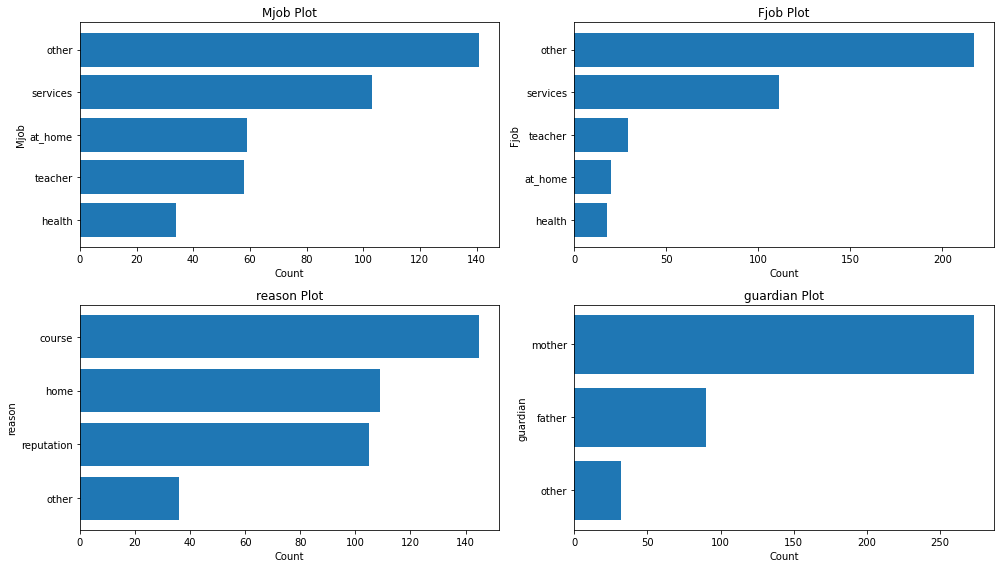

In [0]:
nominal_columns = ['Mjob', 'Fjob', 'reason', 'guardian']

num_columns = 2
num_rows = (len(nominal_columns) + 1) // num_columns  

fig, axes = plt.subplots(num_rows, num_columns, figsize=(14, num_rows *4))
axes = axes.flatten()  

for idx, variable in enumerate(nominal_columns):
    variable_counts = students.groupBy(variable).count().orderBy('count', ascending=True)
    variable_count_list = variable_counts.collect()

    variable_values = [row[variable] for row in variable_count_list]
    counts = [row['count'] for row in variable_count_list]

    axes[idx].barh(variable_values, counts)
    axes[idx].set_xlabel('Count')
    axes[idx].set_ylabel(variable)
    axes[idx].set_title(f'{variable} Plot')

plt.tight_layout()
plt.show()

The bar plots here illustrate parental job types, reasons for school choice, and the primary guardian for students. Most mothers and fathers work in "other" or "services" professions, while fewer are in health or teaching jobs. Reputation and proximity to home are common reasons for school choice. The majority of students list their mother as their primary guardian, followed by fathers and others.

##### 2.1.3. Numeric Variables

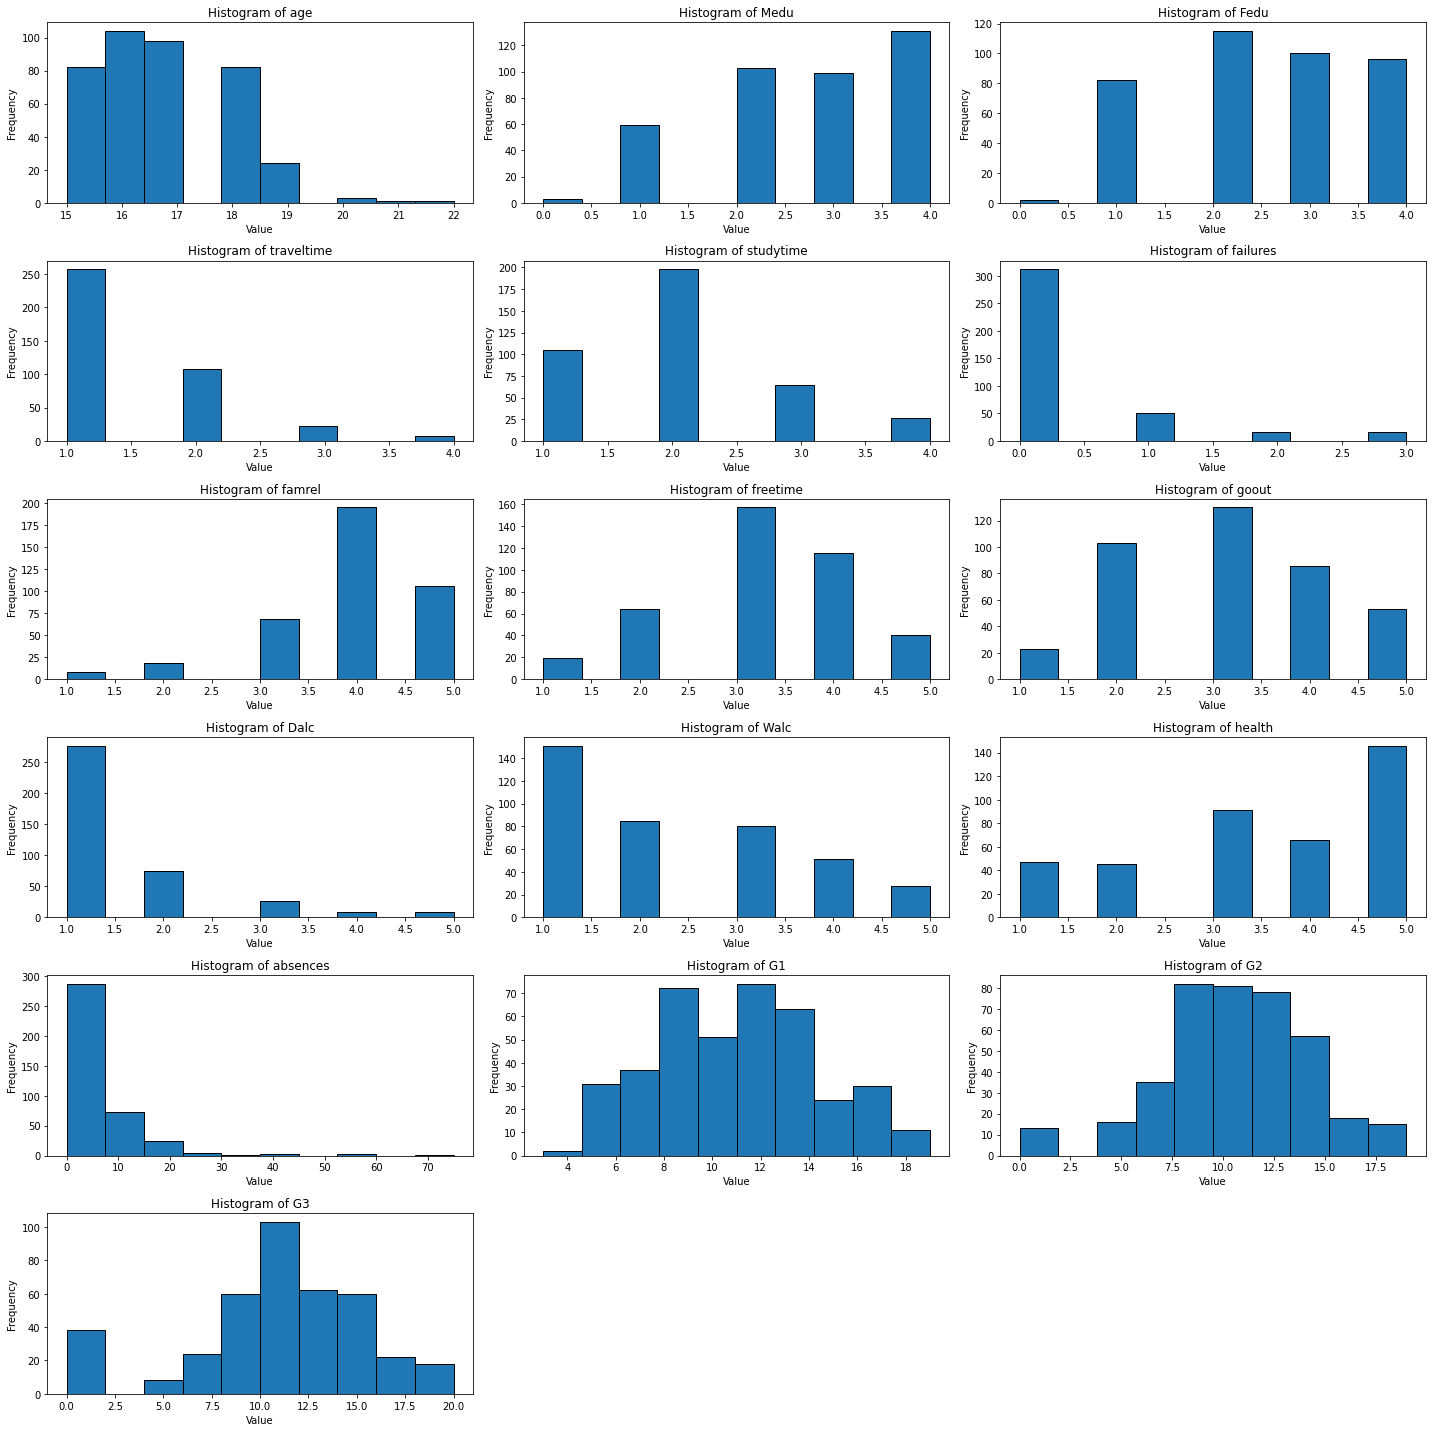

In [0]:
num_vars = len(numeric_columns)
plt.figure(figsize=(20, 20))

for i, variable in enumerate(numeric_columns):
    students1 = students.select(variable).rdd.flatMap(lambda x: x).collect()
    plt.subplot((num_vars // 3) + 1, 3, i + 1)  
    plt.hist(students1, bins=10, edgecolor='k')
    plt.title(f'Histogram of {variable}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

This image presents histograms showing the distribution of numerical variables such as age, parental education, study time, and grades. Most students are aged 15-17, with parents generally having medium to high education levels. Study times are moderate, and most students have no prior class failures. Alcohol consumption is lower on weekdays compared to weekends, and grades (G1, G2, G3) follow a normal distribution. Health scores and absences show students are generally healthy with low absenteeism.

#### 2.2. Correlations

In [0]:
#Putting the numeric columns into a single vector 
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_features")
corr_df = assembler.transform(students).select("numeric_features")

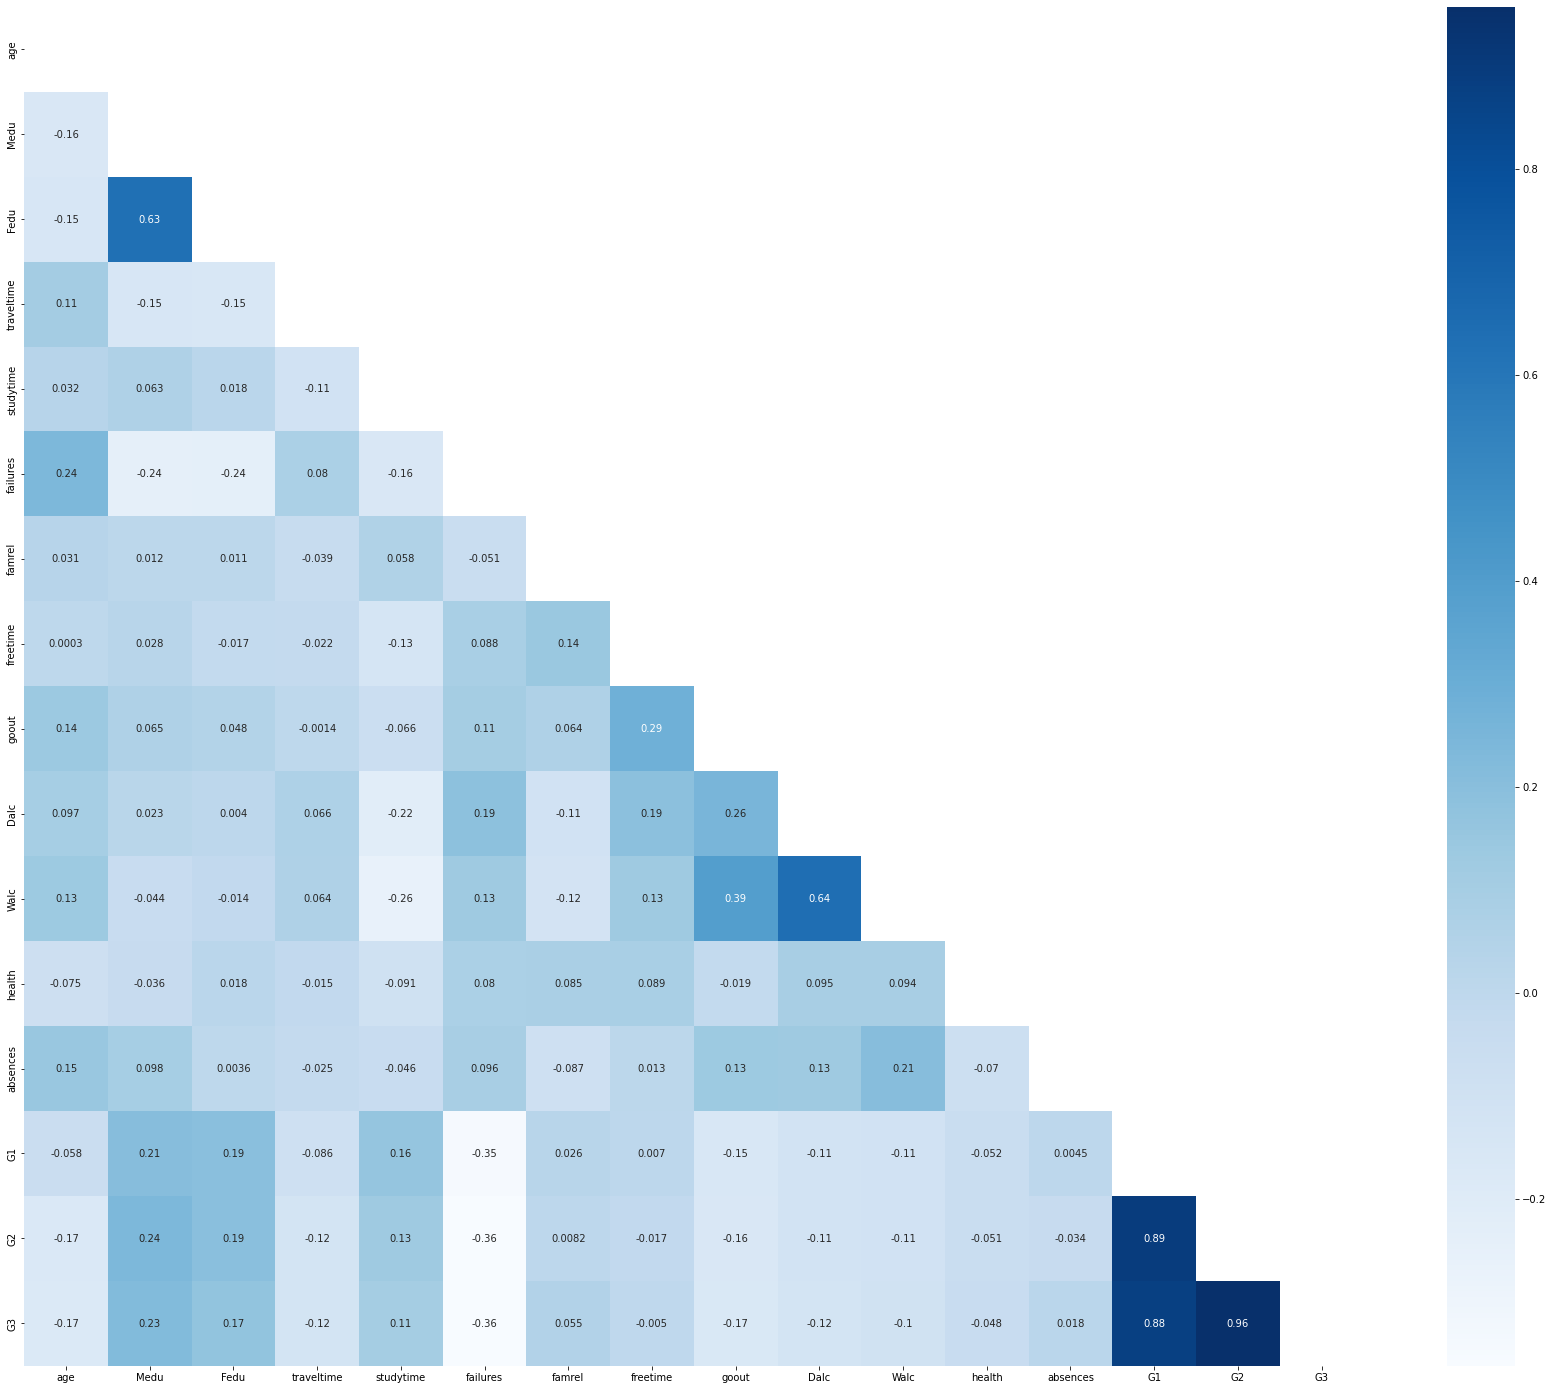

In [0]:
# Calculate the Spearman correlation matrix 
spearman_correlation = Correlation.corr(corr_df, "numeric_features", "spearman").collect()[0][0]

variable_index_mapping = {index: name for index, name in enumerate(numeric_columns)}

mask = np.triu(np.ones_like(spearman_correlation.toArray(), dtype=bool))

plt.figure(figsize=(30, 25))

#Plot the heatmap of the Spearman correlation matrix
sns.heatmap(spearman_correlation.toArray(), cmap="Blues", annot=True, xticklabels=numeric_columns, yticklabels=numeric_columns, mask=mask)
plt.show()

The heatmap reveals strong positive correlations between **G1, G2, and G3**. **Medu** and **Fedu** are moderately correlated, suggesting similar education levels between parents, while **studytime** shows a positive relationship with grades, reflecting its importance for academic success. However, variables like **failures** and **absences** show negative correlations with grades, highlighting their impact on performance. Other variables, such as **age** and **health**, exhibit weak correlations, indicating limited influence on the outcomes measured.

#### 2.3. RDD´S for useful insights

In [0]:
# Creating an RDD
data_rdd = students.select("Dalc", "Walc", "G1", "G2", "G3").rdd.map(lambda row: (row["Dalc"], row["Walc"], row["G1"], row["G2"], row["G3"]))
data = data_rdd.collect()

# Organizing the data into separate lists for each variable
dalc = [row[0] for row in data]
walc = [row[1] for row in data]
g1 = [row[2] for row in data]
g2 = [row[3] for row in data]
g3 = [row[4] for row in data]


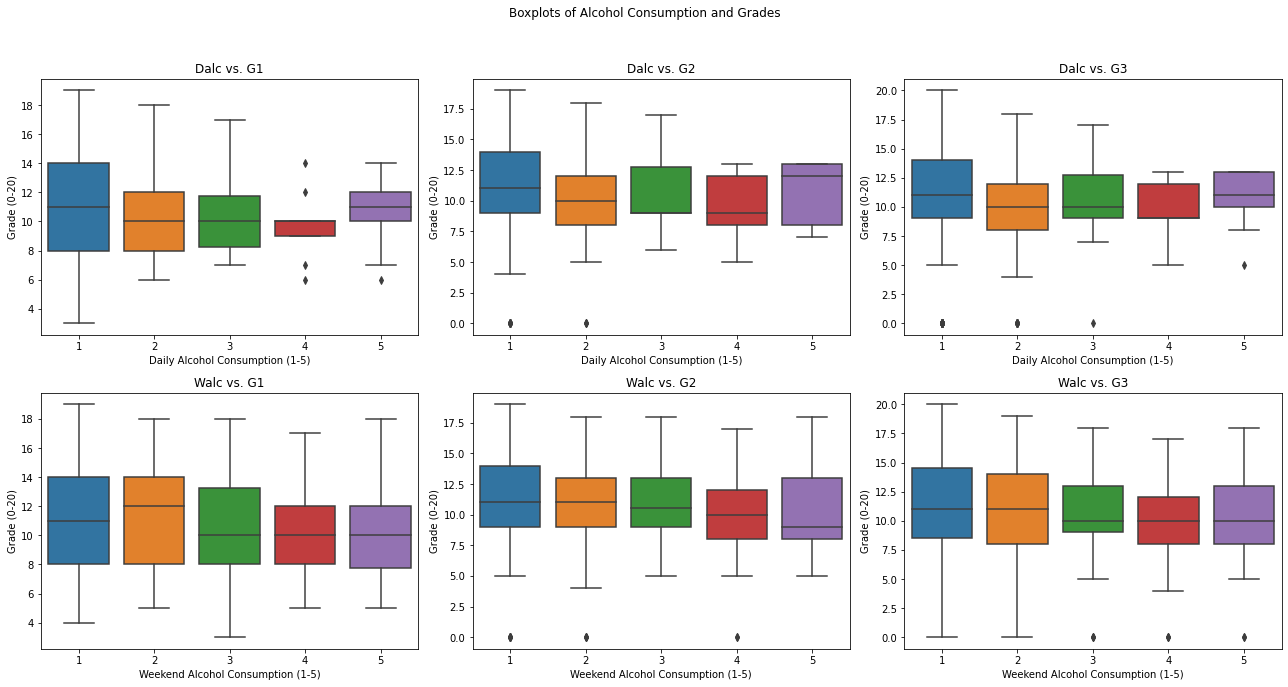

In [0]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Boxplots of Alcohol Consumption and Grades")

# Boxplots for Dalc vs Grades
sns.boxplot(x=dalc, y=g1, ax=axes[0, 0])
axes[0, 0].set_title("Dalc vs. G1")
axes[0, 0].set_xlabel("Daily Alcohol Consumption (1-5)")
axes[0, 0].set_ylabel("Grade (0-20)")

sns.boxplot(x=dalc, y=g2, ax=axes[0, 1])
axes[0, 1].set_title("Dalc vs. G2")
axes[0, 1].set_xlabel("Daily Alcohol Consumption (1-5)")
axes[0, 1].set_ylabel("Grade (0-20)")

sns.boxplot(x=dalc, y=g3, ax=axes[0, 2])
axes[0, 2].set_title("Dalc vs. G3")
axes[0, 2].set_xlabel("Daily Alcohol Consumption (1-5)")
axes[0, 2].set_ylabel("Grade (0-20)")

# Boxplots for Walc vs Grades
sns.boxplot(x=walc, y=g1, ax=axes[1, 0])
axes[1, 0].set_title("Walc vs. G1")
axes[1, 0].set_xlabel("Weekend Alcohol Consumption (1-5)")
axes[1, 0].set_ylabel("Grade (0-20)")

sns.boxplot(x=walc, y=g2, ax=axes[1, 1])
axes[1, 1].set_title("Walc vs. G2")
axes[1, 1].set_xlabel("Weekend Alcohol Consumption (1-5)")
axes[1, 1].set_ylabel("Grade (0-20)")

sns.boxplot(x=walc, y=g3, ax=axes[1, 2])
axes[1, 2].set_title("Walc vs. G3")
axes[1, 2].set_xlabel("Weekend Alcohol Consumption (1-5)")
axes[1, 2].set_ylabel("Grade (0-20)")

# Adjust layout to fit everything nicely
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


The box plots show the relationship between alcohol consumption and grades (G1, G2, G3). Higher daily alcohol consumption (top row) generally correlates with lower grades, particularly at higher levels (4-5). Weekend alcohol consumption (bottom row) shows a similar trend,but less pronounced. Overall, increased alcohol use negatively impacts academic performance.

In [0]:
#Count the total number of rows in the dataset
# Convert DataFrame to RDD
students_rdd = students.rdd
students_rdd.cache()

# Count the number of rows
total_rows = students_rdd.count()
print(f"Total rows: {total_rows}")

Total rows: 395


In [0]:
# Calculate total absences using Map-Reduce
total_absences = students_rdd.map(lambda row: row['absences']).reduce(lambda x, y: x + y)
print(f"Total absences: {total_absences}")


Total absences: 2255


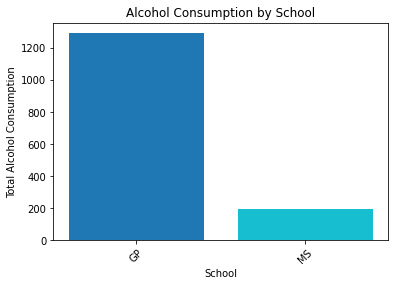

In [0]:
# Map to create key-value pairs with school as key and total alcohol consumption as value
alcohol_consumption = students_rdd.map(lambda row: (row['school'], row['Dalc'] + row['Walc']))

# Reduce by key to sum alcohol consumption for each school
total_alcohol_by_school = alcohol_consumption.reduceByKey(lambda x, y: x + y)

data = total_alcohol_by_school.collect()  # Returns a list of tuples [(school, total_alcohol), ...]

schools, alcohol_consumption = zip(*data)  # Unpack the data into two lists

colors = plt.cm.tab10(np.linspace(0, 1, len(schools)))  # Use a colormap (tab10 in this case)

# Plot the bar chart with unique colors
plt.bar(schools, alcohol_consumption, color=colors)

plt.xlabel('School')
plt.ylabel('Total Alcohol Consumption')
plt.title('Alcohol Consumption by School')
plt.xticks(rotation=45)  # Rotate school labels for better visibility

# Show the plot
plt.show()


The bar chart shows that alcohol consumption is significantly higher in school GP compared to school MS.

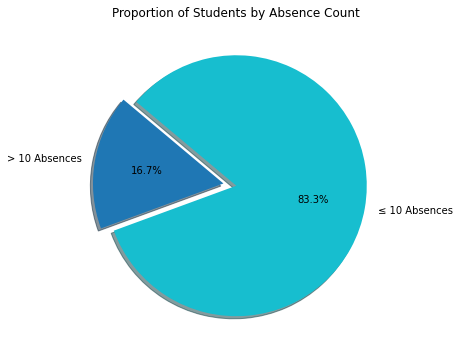

In [0]:
# Filter students with more than 10 absences
high_absence_students = students_rdd.filter(lambda row: row['absences'] > 10)

total_students = students_rdd.count()

# Count students with more than 10 absences
high_absence_count = high_absence_students.count()

# Calculate students with 10 or fewer absences
low_absence_count = total_students - high_absence_count

labels = ['> 10 Absences', '≤ 10 Absences']
sizes = [high_absence_count, low_absence_count]
explode = (0.1, 0)  # Slightly explode the first slice

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

plt.title('Proportion of Students by Absence Count')
plt.show()


The pie chart shows that the majority of students (83.3%) have 10 or fewer absences, while only 16.7% exceed 10 absences.

In [0]:
students_rdd.unpersist()

Out[24]: MapPartitionsRDD[4816] at javaToPython at <unknown>:0

##3. Clustering

#### 3.1. Data Preparation

##### 3.1.1. Encoding

In [0]:
binary_mappings = {'school': {'GP': 0, 'MS': 1},
    'sex': {'F': 0, 'M': 1},
    'address': {'U': 0, 'R': 1},
    'famsize': {'LE3': 0, 'GT3': 1},
    'Pstatus': {'T': 0, 'A': 1},
    'schoolsup': {'no': 0, 'yes': 1},
    'famsup': {'no': 0, 'yes': 1},
    'paid': {'no': 0, 'yes': 1},
    'activities': {'no': 0, 'yes': 1},
    'nursery': {'no': 0, 'yes': 1},
    'higher': {'no': 0, 'yes': 1},
    'internet': {'no': 0, 'yes': 1},
    'romantic': {'no': 0, 'yes': 1}}

# Add new columns for binary encoding
for cols, mapping in binary_mappings.items():
    students = students.withColumn(
        f"{cols}_binary",
        when(students[cols] == list(mapping.keys())[0], list(mapping.values())[0])
        .otherwise(list(mapping.values())[1]))


In [0]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in nominal_columns]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_vec") for col in nominal_columns]

for indexer, encoder in zip(indexers, encoders):
    students = indexer.fit(students).transform(students)
    students = encoder.fit(students).transform(students)

##### 3.1.2. Feature Engineering

In [0]:
binary_columns = [f"{col}_binary" for col in binary_mappings.keys()]
one_hot_columns = [f"{col}_vec" for col in nominal_columns]

# Combine all columns
input_columns = numeric_columns + binary_columns + one_hot_columns
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
students_features = assembler.transform(students)


##### 3.1.3. Scaling

In [0]:
standard_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
standardscaler_model = standard_scaler.fit(students_features)
students_scaled = standardscaler_model.transform(students_features)


#### 3.2. K-Means

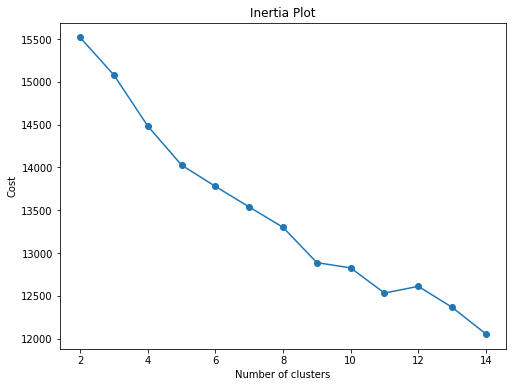

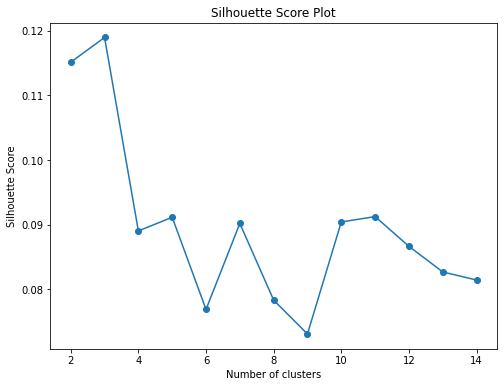

In [0]:
# Evaluate optimal number of clusters
cost = []
silhouette_scores = []
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2, 15):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(students_scaled)
    cost.append(model.summary.trainingCost)

    predictions = model.transform(students_scaled)
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Plot inertia and silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(range(2, 15), cost, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Inertia Plot')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Plot')
plt.show()

Based on this we are gonna try to do the Kmeans clustering with 3, 5, 7, 10 and 11 clusters 

In [0]:
# Define the cluster counts to evaluate
cluster_counts = [4, 5, 6, 7, 10, 11 ]

# Dictionary to store models and predictions for each k
kmeans_models = {}
kmeans_predictions = {}

for k in cluster_counts:
    # Apply KMeans with k clusters
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(students_scaled)
    
    # Store the model
    kmeans_models[k] = model
    
    # Generate predictions
    predictions = model.transform(students_scaled)
    kmeans_predictions[k] = predictions

Visualizing UMAP for k = 4


/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


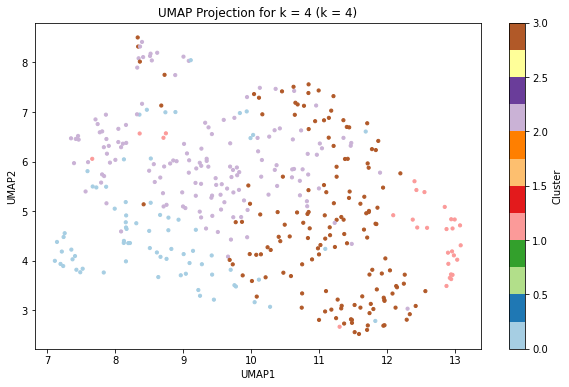

Visualizing UMAP for k = 5


/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


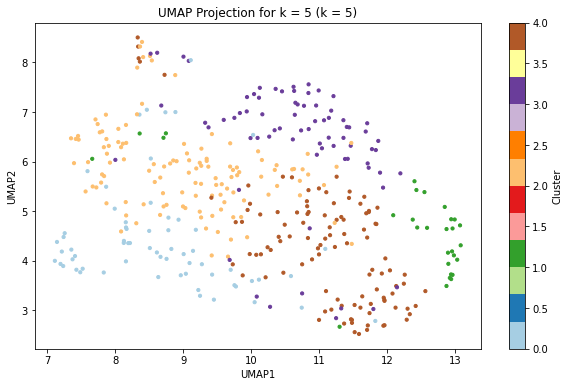

Visualizing UMAP for k = 6


/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


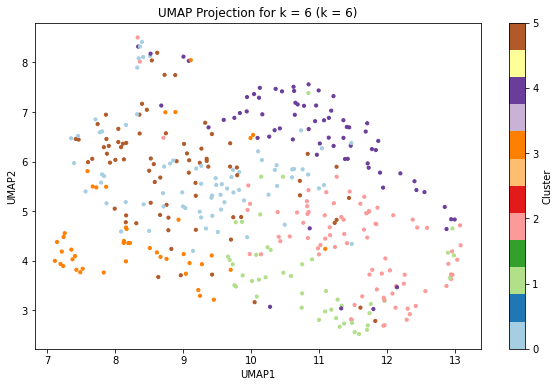

Visualizing UMAP for k = 7


/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


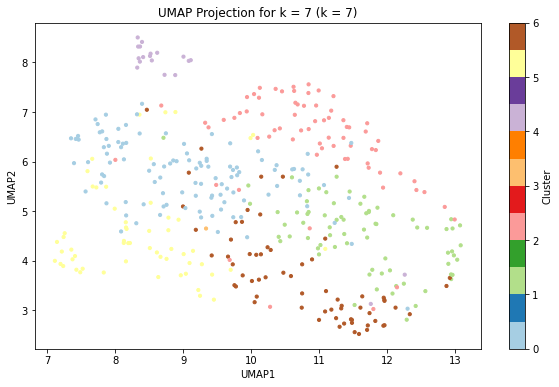

Visualizing UMAP for k = 10


/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


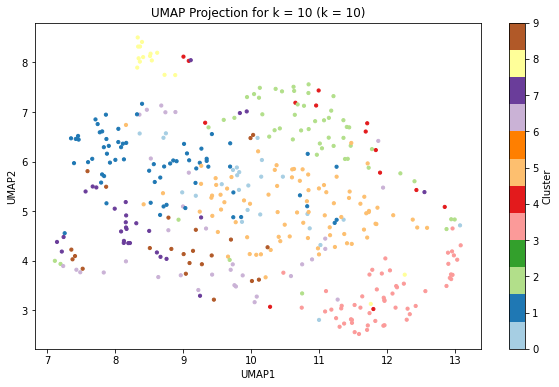

Visualizing UMAP for k = 11


/local_disk0/.ephemeral_nfs/envs/pythonEnv-6ff9eb1f-4b50-433f-a990-a647937648f2/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


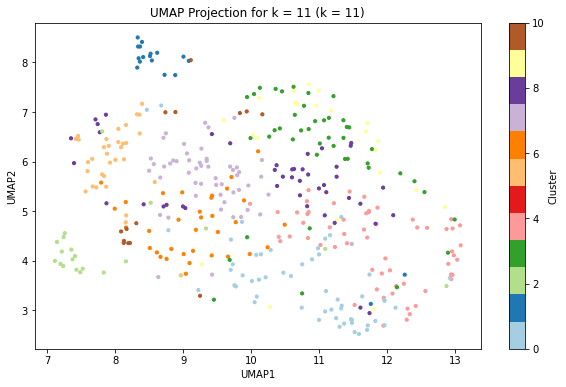

In [0]:
# Function to create and plot UMAP
def plot_umap(predictions, k, title="UMAP Projection with KMeans Clustering"):
    # Convert scaled features to NumPy array
    features_array = np.array(predictions.select("scaledFeatures").rdd.map(lambda row: row["scaledFeatures"].toArray()).collect())
    
    # Apply UMAP for dimensionality reduction
    reducer = umap.UMAP(n_components=2, random_state=42)  # Random state for reproducibility
    embedding = reducer.fit_transform(features_array)
    
    # Extract cluster predictions
    cluster_labels = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()
    
    # Plot UMAP with cluster predictions
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='Paired', s=10)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title(f"{title} (k = {k})")
    plt.show()

# Plot UMAP for each k
for k in cluster_counts:
    print(f"Visualizing UMAP for k = {k}")
    plot_umap(kmeans_predictions[k], k, title=f"UMAP Projection for k = {k}")

##### 3.2.1. Results

Based on the analysis of the UMAPs above, we focused on two clusters from the last image (when k=11), since although most of the clusters were not clearly separable, clusters 1 and 3 stood out as well-defined.

In [0]:
# Function to get cluster characteristics for k = 11
def get_cluster_characteristics_for_k11(predictions, features_list):
    # Convert vector column to array
    predictions = predictions.withColumn("scaled_array", vector_to_array(col("scaledFeatures")))
    
    # Extract each array element into a separate column
    for i in range(len(features_list)):
        predictions = predictions.withColumn(f"scaled_array_{i}", col("scaled_array").getItem(i))

    # Calculate the mean and std dev for each feature in each cluster
    agg_exprs = []
    for i, feature_name in enumerate(features_list):
        agg_exprs.append(F.mean(col(f"scaled_array_{i}")).alias(f"mean_{feature_name}"))
        agg_exprs.append(F.stddev(col(f"scaled_array_{i}")).alias(f"stddev_{feature_name}"))

    cluster_summary = predictions.groupBy("prediction").agg(*agg_exprs).toPandas()
    
    print(f"\nCluster characteristics for k = 11:")
    print(cluster_summary)

    # Get centroids dynamically based on the number of features
    centroids = kmeans_models[11].clusterCenters()
    feature_count = len(centroids[0])  # Dynamically determine feature count
    centroids_df = pd.DataFrame(centroids, columns=[f'Feature_{i+1}' for i in range(feature_count)])
    
    print(f"\nCentroids for k = 11:")
    print(centroids_df)
    
    return cluster_summary, centroids_df

# Analyze clusters for k = 11
features_list = input_columns  # Replace with your actual feature names
cluster_summary, centroids_df = get_cluster_characteristics_for_k11(kmeans_predictions[11], features_list)



Cluster characteristics for k = 11:
    prediction   mean_age  stddev_age  mean_Medu  stddev_Medu  mean_Fedu  \
0            1  13.278901    0.986609   2.232909     1.181586   2.246318   
1            6  13.322438    0.862795   2.014992     0.834765   1.648701   
2            3  13.108709    0.900112   2.678107     0.911288   2.756845   
3            5  13.227447    0.994323   1.522438     0.710018   1.921437   
4            9  12.289415    0.779421   2.449742     0.908507   2.589763   
5            4  12.445787    0.728854   3.437098     0.489834   3.006051   
6            8  13.090898    1.008128   2.512023     0.838708   2.109404   
7            7  12.864063    0.847866   2.378451     0.827556   2.011283   
8           10  14.553924    0.907390   1.370194     0.859148   1.378422   
9            2  13.988560    1.056774   1.781253     0.912260   1.562212   
10           0  13.278901    0.839591   3.095624     0.761506   2.773862   

    stddev_Fedu  mean_traveltime  stddev_traveltim

Below are our conclusions for each segment:
- Cluster 1: Characterized by lower levels of parental education, slightly above average study time, and varied home to school travel times. There is a high presence of romantic relationships, but lower parental job influence.
- Cluster 3: This cluster has higher levels of parental education, particularly the mother's education. Study and travel times are lower, suggesting a more relaxed lifestyle. Students in this cluster also exhibit stronger motivations for studying.

## 4. Graph Frames

#### 4.1. Social Behaviour

In [0]:
# Use the existing DataFrame "students" and add a unique ID column
students = students.withColumn("student_id", monotonically_increasing_id())

# Define edges based on social behavior similarity
similarity_threshold = 1
edges = students.alias("a").join(
    students.alias("b"),
    (
        (abs(col("a.goout") - col("b.goout")) <= similarity_threshold) &
        (abs(col("a.freetime") - col("b.freetime")) <= similarity_threshold) &
        (abs(col("a.Dalc") - col("b.Dalc")) <= similarity_threshold) &
        (abs(col("a.Walc") - col("b.Walc")) <= similarity_threshold))
).filter(col("a.student_id") != col("b.student_id")).select(
    col("a.student_id").alias("src"),
    col("b.student_id").alias("dst")
)

# Define vertices using the existing students DataFrame
vertices = students.select(
    col("student_id").alias("id"),  
    "age", "school", "goout", "freetime", "Dalc", "Walc")

graph = GraphFrame(vertices, edges)

spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

# Display vertices and edges
graph.vertices.show()
graph.edges.show()

number_of_vertices = graph.vertices.count()
number_of_edges = graph.edges.count()

print(f"Number of edges : {number_of_edges}")
print(f"Average degree per vertex: {number_of_edges // number_of_vertices}")

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


+---+---+------+-----+--------+----+----+
| id|age|school|goout|freetime|Dalc|Walc|
+---+---+------+-----+--------+----+----+
|  0| 18|    GP|    4|       3|   1|   1|
|  1| 17|    GP|    3|       3|   1|   1|
|  2| 15|    GP|    2|       3|   2|   3|
|  3| 15|    GP|    2|       2|   1|   1|
|  4| 16|    GP|    2|       3|   1|   2|
|  5| 16|    GP|    2|       4|   1|   2|
|  6| 16|    GP|    4|       4|   1|   1|
|  7| 17|    GP|    4|       1|   1|   1|
|  8| 15|    GP|    2|       2|   1|   1|
|  9| 15|    GP|    1|       5|   1|   1|
| 10| 15|    GP|    3|       3|   1|   2|
| 11| 15|    GP|    2|       2|   1|   1|
| 12| 15|    GP|    3|       3|   1|   3|
| 13| 15|    GP|    3|       4|   1|   2|
| 14| 15|    GP|    2|       5|   1|   1|
| 15| 16|    GP|    4|       4|   1|   2|
| 16| 16|    GP|    3|       2|   1|   2|
| 17| 16|    GP|    2|       3|   1|   1|
| 18| 17|    GP|    5|       5|   2|   4|
| 19| 16|    GP|    3|       1|   1|   3|
+---+---+------+-----+--------+---

Edges represent connections between students who have similar social behaviors, determined by the similarity threshold. There are 44,326 edges in the graph, highlighting a high level of social connectivity among students.
Based on the average degree per vertex, we conclude that each student, on average, is connected to approximately 112 other students based on social behavior similarity.

In [0]:
print("Top 5 InDegrees:" )
graph.inDegrees.orderBy(desc('inDegree')).limit(5).show()
print("Bottom 5 InDegrees:")
graph.inDegrees.orderBy('inDegree', ascending = True).limit(5).show()
print("Top 5 OutDegrees:")
graph.outDegrees.orderBy(desc('outDegree')).limit(5).show()
print("Bottom 5 OutDegrees:")
graph.outDegrees.orderBy('outDegree', ascending=True).limit(5).show()

Top 5 InDegrees:
+---+--------+
| id|inDegree|
+---+--------+
|325|     239|
|341|     239|
| 48|     239|
| 44|     239|
|206|     239|
+---+--------+

Bottom 5 InDegrees:
+---+--------+
| id|inDegree|
+---+--------+
|369|       2|
| 89|       3|
|236|       3|
|168|       5|
| 66|       6|
+---+--------+

Top 5 OutDegrees:
+---+---------+
| id|outDegree|
+---+---------+
|325|      239|
|341|      239|
| 48|      239|
| 44|      239|
|206|      239|
+---+---------+

Bottom 5 OutDegrees:
+---+---------+
| id|outDegree|
+---+---------+
|369|        2|
| 89|        3|
|236|        3|
|168|        5|
| 66|        6|
+---+---------+



The in-degrees represent how many students perceive a particular student as behaviorally similar, while the out-degrees represent how many students a particular student identifies as behaviorally similar. 

**Results:**

- **Top 5 Degrees:** Students with IDs 325, 341, 48, 44, and 206 have the highest degrees, with 239 connections each for both in-degrees and out-degrees. These students are widely recognized by their peers as behaviorally similar and also perceive many others as similar to themselves. This suggests that they may exhibit traits or behaviors that are broadly relatable or influential. Their central position in the network might indicate they play prominent social roles, are well-recognized figures, or align closely with group norms and expectations. Additionally, their high out-degrees suggest they might have an inclusive or broad perspective on similarity, reflecting traits like sociability or a high level of engagement within the group.


- **Bottom 5 Degrees:** Students with IDs 369, 89, 236, 168, and 66 have the lowest degrees, ranging from 2 to 6 connections for both in-degrees and out-degrees. These students are least recognized by their peers as behaviorally similar and also identify the fewest others as similar to themselves. This might indicate that they have more distinct or unique behaviors that set them apart from the majority or that they are less visible in social interactions. Alternatively, their position in the network might suggest a more peripheral role, limited interaction, or participation in smaller, more exclusive groups. Their low out-degrees could also reflect a selective approach to identifying similarity or a lower level of engagement within the group.


The results are the same for in-degrees and out-degrees because the dataset likely represents a close-knit group of students with shared characteristics. The data indicates that there are only two schools represented, and the students’ ages are fairly similar, suggesting that they might live in close proximity to each other or share similar social environments. These factors likely contribute to mutual recognition of behavioral similarity, as students from similar backgrounds and age groups are more likely to interact and perceive each other as relatable. This shared context could naturally lead to symmetric relationships, where similarity is recognized both ways.


In [0]:
print("Motif Finding:")
motifs = graph.find("(a)-[]->(b); !(b)-[]->(a)")
motifs.show()

Motif Finding:
+---+---+
|  a|  b|
+---+---+
+---+---+



Motif finding involves identifying recurring connection patterns within a graph. In this case, the query searches for directed one-way relationships
The absence of one-way relationships aligns with the earlier observation that the graph is symmetric. In this dataset, if a student identifies another as behaviorally similar, the reverse is also true. Consequently, the graph does not contain asymmetric relationships, which is why the motif-finding query returned no results.

In [0]:
print("PageRank:")
pagerank = graph.pageRank(resetProbability=0.15, maxIter=10)
pagerank.vertices.orderBy("pagerank", ascending=False).show()

PageRank:
+---+---+------+-----+--------+----+----+------------------+
| id|age|school|goout|freetime|Dalc|Walc|          pagerank|
+---+---+------+-----+--------+----+----+------------------+
|206| 16|    GP|    3|       3|   2|   2|1.8314902549592582|
|141| 16|    GP|    3|       3|   2|   2|1.8314902549592582|
| 44| 16|    GP|    3|       3|   2|   2|1.8314902549592582|
|341| 18|    GP|    3|       3|   2|   2|1.8314902549592582|
|325| 18|    GP|    3|       3|   2|   2|1.8314902549592582|
| 48| 15|    GP|    3|       3|   2|   2|1.8314902549592582|
|356| 17|    MS|    3|       3|   1|   2|1.7623521829267756|
|329| 17|    GP|    3|       3|   1|   2|1.7623521829267756|
|316| 18|    GP|    3|       3|   1|   2|1.7623521829267756|
|286| 18|    GP|    3|       3|   1|   2|1.7623521829267756|
| 10| 15|    GP|    3|       3|   1|   2|1.7623521829267756|
|344| 18|    GP|    3|       3|   1|   2|1.7623521829267756|
|285| 17|    GP|    3|       3|   1|   2|1.7623521829267756|
|186| 16|    G

The PageRank algorithm measures the relative importance of nodes in the graph based on their connections. It assigns a score to each node, where a higher score indicates greater influence or centrality in the network. This algorithm is often used to rank nodes in terms of their ability to "spread information" or their prominence in the network.
Students with the highest PageRank scores include IDs 206, 141, 44, 341, 325, and 48, all scoring approximately 1.831. These students are the most central or influential in the network. Their high scores suggest that they are well-connected and often linked by other influential students. These individuals likely play a significant role in information flow or group dynamics.

In [0]:
print("Label Propagation:")
label_propagation = graph.labelPropagation(maxIter=10)
label_counts = label_propagation.groupBy("label").count()
label_counts.orderBy("count", ascending=False).show()


Label Propagation:
+-----+-----+
|label|count|
+-----+-----+
|  137|  386|
|  218|    9|
+-----+-----+



The Label Propagation algorithm identifies communities (clusters) of nodes in the graph based on their connections. Each node is assigned a label, which propagates through the graph over a series of iterations, grouping nodes that are closely connected into the same community.  

**Results:**
- Label 137: Contains the majority of nodes, with 386 students assigned to this community. This suggests that most of the graph forms a single, highly connected cluster. The large size of this community suggests that the graph is highly interconnected, with most nodes having direct or indirect connections to each other.
This could indicate a lack of distinct subgroups or that the dataset captures a relatively homogeneous set of relationships.
- Label 218: Contains only 9 students, indicating a small, distinct subgroup within the graph. The small number of students in this community might reflect a group of nodes with limited connections to the main network or unique behavioral traits that set them apart.


NetworkX Visualization:


/databricks/spark/python/pyspark/sql/dataframe.py:149: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


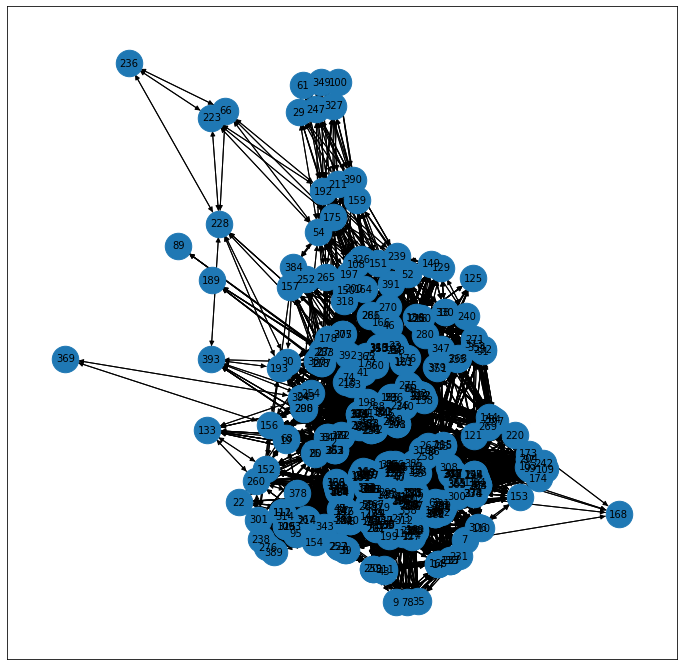

In [0]:
print("NetworkX Visualization:")
vertices_pd = graph.vertices.toPandas()
edges_pd = graph.edges.toPandas()
G = nx.from_pandas_edgelist(edges_pd, "src", "dst", create_using=nx.DiGraph())
for _, row in vertices_pd.iterrows():
    G.nodes[row["id"]]["label"] = row["id"]

plt.figure(figsize=(12, 12))
nx.draw_networkx(G, with_labels=True, node_size=700, font_size=10)
plt.show()

#### 4.2. Family Background

In [0]:
family_vertices = students.select(
    col("student_id").alias("id"), 
    col("guardian"), 
    col("famsize"),
    col("Pstatus"))

# Define edges based on family background similarity
family_edges = students.alias("a").join(
    students.alias("b"),
    (
        (col("a.guardian") == col("b.guardian")) |  
        (col("a.famsize") == col("b.famsize")) |   
        (col("a.Pstatus") == col("b.Pstatus"))     
) & (col("a.student_id") != col("b.student_id"))).select(
    col("a.student_id").alias("src"),
    col("b.student_id").alias("dst"))

family_graph = GraphFrame(family_vertices, family_edges)

number_of_vertices_f = family_graph.vertices.count()
number_of_edges_f = family_graph.edges.count()

print(f"Number of edges : {number_of_edges_f}")
print(f"Average degree per vertex: {number_of_edges_f // number_of_vertices_f}")


/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Number of edges : 149818
Average degree per vertex: 379


There are 149818 edges in the family graph, representing connections between students with similar family backgrounds. The average degree per vertex is 379, indicating that, on average, each student shares similarities in family attributes with a large number of peers.

In [0]:
print("Top 5 InDegrees:" )
family_graph.inDegrees.orderBy(desc('inDegree')).limit(5).show()
print("Bottom 5 InDegrees:")
family_graph.inDegrees.orderBy('inDegree', ascending = True).limit(5).show()
print("Top 5 OutDegrees:")
family_graph.outDegrees.orderBy(desc('outDegree')).limit(5).show()
print("Bottom 5 OutDegrees:")
family_graph.outDegrees.orderBy('outDegree', ascending=True).limit(5).show()

Top 5 InDegrees:
+---+--------+
| id|inDegree|
+---+--------+
|243|     392|
|348|     392|
|367|     392|
| 29|     392|
|277|     392|
+---+--------+

Bottom 5 InDegrees:
+---+--------+
| id|inDegree|
+---+--------+
|390|     154|
| 52|     196|
| 14|     307|
|137|     307|
|336|     307|
+---+--------+

Top 5 OutDegrees:
+---+---------+
| id|outDegree|
+---+---------+
|243|      392|
|348|      392|
|367|      392|
| 29|      392|
|277|      392|
+---+---------+

Bottom 5 OutDegrees:
+---+---------+
| id|outDegree|
+---+---------+
|390|      154|
| 52|      196|
| 14|      307|
|137|      307|
|336|      307|
+---+---------+



**Results:**
- **Top 5 Degrees:** Entities with IDs 243, 348, 367, 29, and 277 have the highest in-degrees and out-degrees, each with 392 connections. These entities are recognized by many as behaviorally similar and also identify a large number of others as similar, indicating they are central figures in the network with broad influence and engagement. Their position suggests they have similar family backgrounds.

- **Bottom 5 Degrees**: Entities with IDs 390, 52, 14, 137, and 336 have the lowest in-degrees and out-degrees, ranging from 154 to 307 connections. These entities are less recognized by others as behaviorally similar and also identify fewer others as similar, suggesting a more peripheral or distinct role within the network. Their lower engagement may indicate they have more unique backgrounds.

Again, the results are the same for in-degrees and out-degrees because the dataset likely represents a close-knit group of students with shared characteristics. 

In [0]:
print("Motif Finding:")
motifs = family_graph.find("(a)-[]->(b); !(b)-[]->(a)")
motifs.show()

Motif Finding:
+---+---+
|  a|  b|
+---+---+
+---+---+



Once again, the graph does not contain asymmetric relationships, which is why the motif-finding query returned no results.

In [0]:
print("Label Propagation:")
label_propagation = family_graph.labelPropagation(maxIter=10)
label_counts = label_propagation.groupBy("label").count()
label_counts.orderBy("count", ascending=False).show()

Label Propagation:
+-----+-----+
|label|count|
+-----+-----+
|  137|  395|
+-----+-----+



**Results:**

- **Label 137:** This community contains all 395 nodes in the graph, indicating that the graph forms a single, highly connected cluster.

The large size of this single community suggests a homogeneous and interconnected network with no distinct subgroups. This means that all nodes share strong or uniform connections, reflecting a lack of diversity in backgrounds.

In [0]:
print("PageRank:")
pagerank = family_graph.pageRank(resetProbability=0.15, maxIter=10)
pagerank.vertices.orderBy("pagerank", ascending=False).show()

PageRank:
+---+--------+-------+-------+------------------+
| id|guardian|famsize|Pstatus|          pagerank|
+---+--------+-------+-------+------------------+
|347|  mother|    GT3|      T|1.0285416726505459|
| 78|  mother|    GT3|      T|1.0285416726505459|
| 93|  mother|    GT3|      T|1.0285416726505459|
|365|  mother|    GT3|      T|1.0285416726505459|
|136|  mother|    GT3|      T|1.0285416726505459|
|373|  mother|    GT3|      T|1.0285416726505459|
|196|  mother|    GT3|      T|1.0285416726505459|
| 24|  mother|    GT3|      T|1.0285416726505459|
|381|  mother|    GT3|      T|1.0285416726505459|
|204|  mother|    GT3|      T|1.0285416726505459|
| 96|  mother|    GT3|      T|1.0285416726505459|
|131|  mother|    GT3|      T|1.0285416726505459|
| 81|  mother|    GT3|      T|1.0285416726505459|
| 17|  mother|    GT3|      T|1.0285416726505459|
|387|  mother|    GT3|      T|1.0285416726505459|
|321|  mother|    GT3|      T|1.0285416726505459|
|345|  mother|    GT3|      T|1.02854167

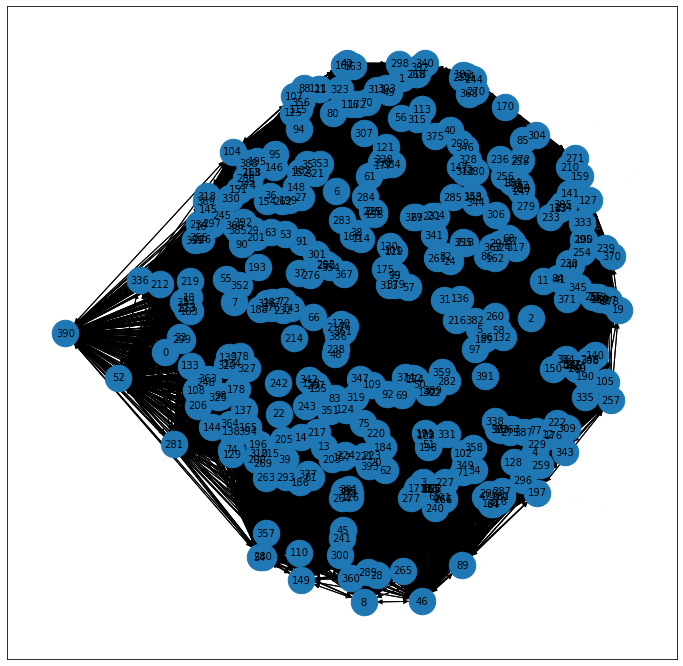

In [0]:
# Visualize the graph with NetworkX
vertices_pd = family_graph.vertices.toPandas()
edges_pd = family_graph.edges.toPandas()

G = nx.from_pandas_edgelist(edges_pd, "src", "dst", create_using=nx.DiGraph())
for _, row in vertices_pd.iterrows():
    G.nodes[row["id"]]["label"] = row["id"]

plt.figure(figsize=(12, 12))
nx.draw_networkx(G, with_labels=True, node_size=700, font_size=10)
plt.show()


#### 4.3. Academic Background

In [0]:
academic_vertices = students.select(col("student_id").alias("id"),  
    col("G1"), 
    col("G2"), 
    col("G3"))

# Define edges based on academic performance similarity
academic_edges = students.alias("a").join(students.alias("b"),
    ((abs(col("a.G1") - col("b.G1")) <= 5) &  
        (abs(col("a.G2") - col("b.G2")) <= 5) &  
        (abs(col("a.G3") - col("b.G3")) <= 5)   
    ) & (col("a.student_id") != col("b.student_id"))).select(
    col("a.student_id").alias("src"),
    col("b.student_id").alias("dst"))

academic_graph = GraphFrame(academic_vertices, academic_edges)

number_of_vertices_a = academic_graph.vertices.count()
number_of_edges_a = academic_graph.edges.count()

print(f"Number of edges : {number_of_edges_a}")
print(f"Average degree per vertex: {number_of_edges_a // number_of_vertices_a}")

/databricks/spark/python/pyspark/sql/dataframe.py:170: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


Number of edges : 86996
Average degree per vertex: 220


There are 86996 edges in the academic graph, representing connections between students with similar academic performance. The average degree per vertex is 220, indicating that, on average, each student is academically similar to 220 other peers.

In [0]:
print("Top 5 InDegrees:" )
academic_graph.inDegrees.orderBy(desc('inDegree')).limit(5).show()
print("Bottom 5 InDegrees:")
academic_graph.inDegrees.orderBy('inDegree', ascending = True).limit(5).show()
print("Top 5 OutDegrees:")
academic_graph.outDegrees.orderBy(desc('outDegree')).limit(5).show()
print("Bottom 5 OutDegrees:")
academic_graph.outDegrees.orderBy('outDegree', ascending=True).limit(5).show()

Top 5 InDegrees:
+---+--------+
| id|inDegree|
+---+--------+
|257|     313|
|322|     313|
|319|     313|
| 28|     313|
| 77|     313|
+---+--------+

Bottom 5 InDegrees:
+---+--------+
| id|inDegree|
+---+--------+
|130|       9|
|135|      19|
|137|      21|
|153|      22|
|144|      22|
+---+--------+

Top 5 OutDegrees:
+---+---------+
| id|outDegree|
+---+---------+
|257|      313|
|322|      313|
|319|      313|
| 28|      313|
| 77|      313|
+---+---------+

Bottom 5 OutDegrees:
+---+---------+
| id|outDegree|
+---+---------+
|130|        9|
|135|       19|
|137|       21|
|153|       22|
|144|       22|
+---+---------+



**Results**
- **Top 5 Degrees:**  Students with IDs 257, 322, 319, 28, and 77 have the highest degrees, with 313 connections each for both in-degrees and out-degrees. These students are central to the academic similarity graph, likely reflecting their grades being broadly relatable or "average," allowing them to connect with many others.

- **Bottom 5 Degrees:** Students with IDs 130, 135, 137, 153, and 144 have the lowest degrees, with 9 to 22 connections for both in-degrees and out-degrees. These students may have more unique academic performance patterns, setting them apart from the majority.

In [0]:
print("Motif Finding:")
motifs = academic_graph.find("(a)-[]->(b); !(b)-[]->(a)")
motifs.show()

Motif Finding:
+---+---+
|  a|  b|
+---+---+
+---+---+



In [0]:
print("Label Propagation:")
label_propagation = academic_graph.labelPropagation(maxIter=10)
label_counts = label_propagation.groupBy("label").count()
label_counts.orderBy("count", ascending=False).show()

Label Propagation:
+-----+-----+
|label|count|
+-----+-----+
|  218|  357|
|  146|   25|
|  137|   13|
+-----+-----+



**Results:**

- **Label 218:** This community is the largest, with **357 students**. The dominance of this label suggests that most students have similar academic performance, leading to a highly interconnected main group, likely reflecting shared or average academic performance across the dataset.
- **Label 146:** A smaller subgroup with **25 students**, potentially indicating a distinct academic cluster with unique performance patterns.
- **Label 137:** The smallest community, consisting of only **13 students**, likely representing a very specific or isolated group of students based on academic similarity.

In [0]:
print("PageRank:")
pagerank = academic_graph.pageRank(resetProbability=0.15, maxIter=10)
pagerank.vertices.orderBy("pagerank", ascending=False).show()

PageRank:
+---+---+---+---+------------------+
| id| G1| G2| G3|          pagerank|
+---+---+---+---+------------------+
| 18|  6|  5|  5|1.2973057267600008|
|384|  6|  5|  5|1.2973057267600006|
|373|  6|  5|  5|1.2973057267600006|
|319| 11| 11| 11|1.2868142296312022|
| 77| 11| 11| 11|1.2868142296312022|
|272| 11| 11| 11|1.2868142296312022|
|257| 11| 11| 11|1.2868142296312022|
|231| 11| 11| 11|1.2868142296312022|
| 28| 11| 11| 11|1.2868142296312022|
|322| 11| 11| 11|1.2868142296312022|
| 81| 11| 10| 11|1.2683699157550474|
| 93| 11| 10| 10|1.2680030963239963|
|344| 11| 10| 10|1.2680030963239963|
|327| 11| 10| 10|1.2680030963239963|
|368| 11| 10| 10|1.2680030963239963|
| 88| 11| 10| 10|1.2680030963239963|
|133| 12| 11| 11|1.2675877242882223|
|290| 12| 11| 11| 1.267587724288222|
|379| 10| 10| 10|1.2567897911995254|
|274| 10| 10| 10|1.2567897911995254|
+---+---+---+---+------------------+
only showing top 20 rows



  - Students with the highest PageRank scores include IDs `18`, `384`, and `373`, each scoring approximately **1.297**. These students are central and influential in the academic similarity network. Their grades (`G1=6`, `G2=5`, `G3=5`) likely place them within a range that connects them to many other students.

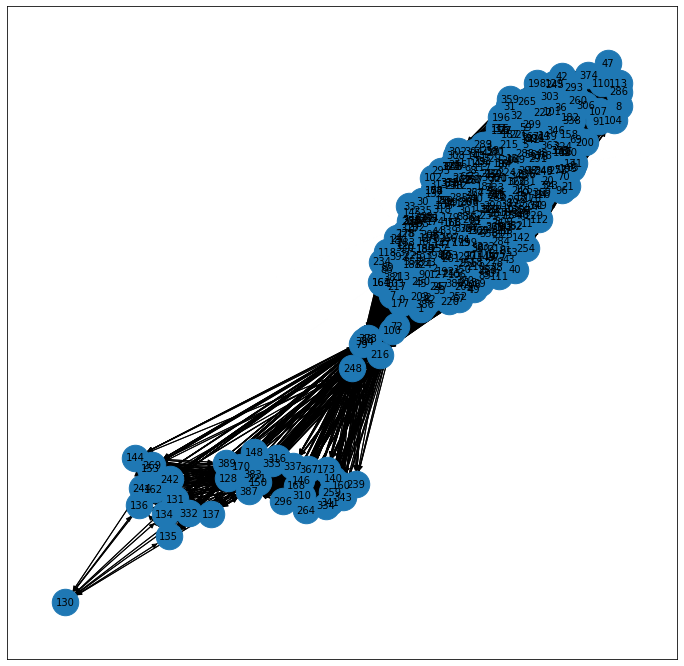

In [0]:
# Visualize the graph with NetworkX
vertices_pd = academic_graph.vertices.toPandas()
edges_pd = academic_graph.edges.toPandas()

G = nx.from_pandas_edgelist(edges_pd, "src", "dst", create_using=nx.DiGraph())
for _, row in vertices_pd.iterrows():
    G.nodes[row["id"]]["label"] = row["id"]

plt.figure(figsize=(12, 12))
nx.draw_networkx(G, with_labels=True, node_size=700, font_size=10)
plt.show()

##5. Conclusion

In conclusion, the complexity and unpredictability of individual traits made clustering students difficult. Nonetheless, our study provided some useful insights. Key findings, such as variations in parental education levels, study habits, and motives, revealed at least 2 different student segments. While clustering is not a perfect solution, these insights aligned with our initial exploration and our network analysis, can help lead focused actions to better serve students based on their specific needs and behaviors.